In [1]:
%reload_ext autoreload
%autoreload 2

# Load the memories

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [8]:
# Manually load the two memories
job_id_0 = "cqz92ybczq6g0081h1t0"
job_id_1 = "cqz92zvdvs8g008j5y9g"

job_0 = provider.retrieve_job(job_id_0)
job_1 = provider.retrieve_job(job_id_1)

mmr_0 = job_0.result().get_memory()
mmr_1 = job_1.result().get_memory()

print(f"shape of mmr_0: {mmr_0.shape}")
print(f"shape of mmr_1: {mmr_1.shape}")

shape of mmr_0: (15748, 254)
shape of mmr_1: (15748, 254)


In [10]:
# Check the layouts
layout_0 = job_0.initial_layouts()
layout_1 = job_1.initial_layouts()

print(f"layout_0: {layout_0}")
print(f"layout_1: {layout_1}")

layout_0: [{"Qubit(QuantumRegister(127, 'q'), 0)": '0', "Qubit(QuantumRegister(127, 'q'), 1)": '1', "Qubit(QuantumRegister(127, 'q'), 2)": '2', "Qubit(QuantumRegister(127, 'q'), 3)": '3', "Qubit(QuantumRegister(127, 'q'), 4)": '4', "Qubit(QuantumRegister(127, 'q'), 5)": '5', "Qubit(QuantumRegister(127, 'q'), 6)": '6', "Qubit(QuantumRegister(127, 'q'), 7)": '7', "Qubit(QuantumRegister(127, 'q'), 8)": '8', "Qubit(QuantumRegister(127, 'q'), 9)": '9', "Qubit(QuantumRegister(127, 'q'), 10)": '10', "Qubit(QuantumRegister(127, 'q'), 11)": '11', "Qubit(QuantumRegister(127, 'q'), 12)": '12', "Qubit(QuantumRegister(127, 'q'), 13)": '13', "Qubit(QuantumRegister(127, 'q'), 14)": '14', "Qubit(QuantumRegister(127, 'q'), 15)": '15', "Qubit(QuantumRegister(127, 'q'), 16)": '16', "Qubit(QuantumRegister(127, 'q'), 17)": '17', "Qubit(QuantumRegister(127, 'q'), 18)": '18', "Qubit(QuantumRegister(127, 'q'), 19)": '19', "Qubit(QuantumRegister(127, 'q'), 20)": '20', "Qubit(QuantumRegister(127, 'q'), 21)": '2

# Fit 1D gaussian

In [158]:
# Take data for 1 qubit
import numpy as np

QUBIT = 20

# HARDCODED for 127 qubits
mmr_0_q = mmr_0[:, [QUBIT, QUBIT+127]]
mmr_1_q = mmr_1[:, [QUBIT, QUBIT+127]]

print(f"mmr_0_q shape: {mmr_0_q.shape}")
print(f"mmr_1_q shape: {mmr_1_q.shape}")

mmr_0_1D = mmr_0_q.flatten().real
mmr_1_1D = mmr_1_q.flatten().real

mmr_total = np.concatenate((mmr_0_1D, mmr_1_1D))

print(mmr_total.shape)

mmr_0_q shape: (15748, 2)
mmr_1_q shape: (15748, 2)
(62992,)


In [159]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Rescale the data
scaler = StandardScaler()
mmr_tot_scaled = scaler.fit_transform(mmr_total.reshape(-1, 1))

# Fit the gmm
gmm = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
gmm.fit(mmr_tot_scaled)

print(f"Means: {gmm.means_}")
print(f"Coefs: {gmm.weights_}")
print(f"cov: {gmm.covariances_}")

Means: [[ 0.92489397]
 [-0.92002144]]
Coefs: [0.49867947 0.50132053]
cov: [[0.14907872]]


# Plot the gaussians

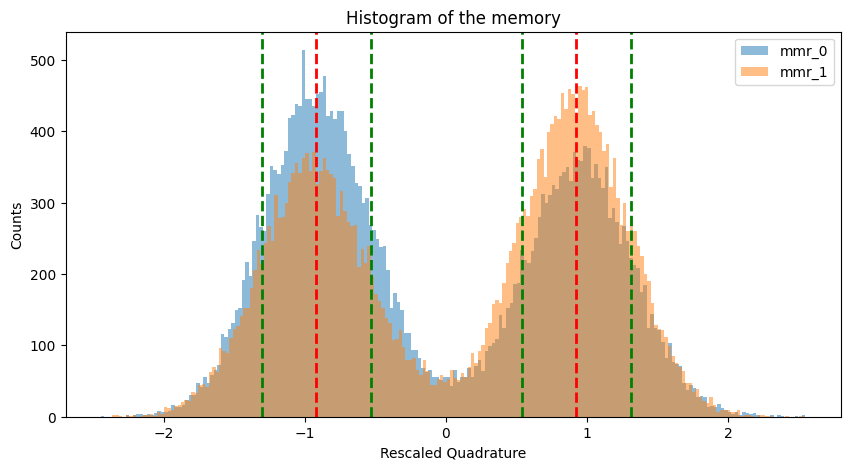

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(scaler.transform(mmr_0_1D.reshape(-1, 1)),
         bins=200, alpha=0.5, label="mmr_0")
plt.hist(scaler.transform(mmr_1_1D.reshape(-1, 1)),
         bins=200, alpha=0.5, label="mmr_1")
plt.axvline(gmm.means_[0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(gmm.means_[1], color='r', linestyle='dashed', linewidth=2)
plt.axvline(gmm.means_[0] + np.sqrt(gmm.covariances_[0]),
            color='g', linestyle='dashed', linewidth=2)
plt.axvline(gmm.means_[0] - np.sqrt(gmm.covariances_[0]),
            color='g', linestyle='dashed', linewidth=2)
plt.axvline(gmm.means_[1] + np.sqrt(gmm.covariances_[0]),
            color='g', linestyle='dashed', linewidth=2)
plt.axvline(gmm.means_[1] - np.sqrt(gmm.covariances_[0]),
            color='g', linestyle='dashed', linewidth=2)
plt.xlabel("Rescaled Quadrature")
plt.ylabel("Counts")
plt.title("Histogram of the memory")
plt.legend()
plt.show()

# calculate countMat and pSoft

In [161]:
# rescale the flat memories
resc_0 = scaler.transform(mmr_0_1D.reshape(-1, 1))
resc_1 = scaler.transform(mmr_1_1D.reshape(-1, 1))

# Predict the labels
countMat_0 = gmm.predict(resc_0)
countMat_1 = gmm.predict(resc_1)

# Get probs
probs_0 = gmm.predict_proba(resc_0)
probs_1 = gmm.predict_proba(resc_1)

# Get pSoft


def compute_misassignment_probs(probs):
    p_high = np.max(probs, axis=1)
    p_lower = np.min(probs, axis=1)
    misassignment_probs = 1 / (1 + (p_high / p_lower))
    return misassignment_probs


pSoft_0 = compute_misassignment_probs(probs_0)
pSoft_1 = compute_misassignment_probs(probs_1)

print(f"misassignment_probs_0: {pSoft_0}")
print(f"misassignment_probs_1: {pSoft_1}")

misassignment_probs_0: [1.08209740e-06 1.03674843e-05 1.00116594e-07 ... 1.07011218e-09
 3.57577425e-03 7.38785301e-04]
misassignment_probs_1: [9.17444874e-05 2.13298118e-09 1.91983826e-08 ... 1.82377273e-05
 1.78535151e-06 3.30106190e-02]


# post select sure scnd msmt

In [171]:
threshold = 0.5e-2  # it is more certain then 0.5% misassignment

# Reshape the pSoft arrays to match the original shape (N_shots, 2)
pSoft_0_reshaped = pSoft_0.reshape(-1, 2)
pSoft_1_reshaped = pSoft_1.reshape(-1, 2)

# Apply the threshold to the second measurement's misassignment probability
# We're interested in filtering based on the second measurement
mask_0 = pSoft_0_reshaped[:, 1] <= threshold
mask_1 = pSoft_1_reshaped[:, 1] <= threshold

# Filter the original and scaled data based on this mask
# Remember, each "row" in your reshaped arrays corresponds to two flattened points in your 1D arrays
filtered_mmr_0_q = mmr_0_q[mask_0, :]
filtered_mmr_1_q = mmr_1_q[mask_1, :]

filtered_resc_0 = resc_0.reshape(-1, 2)[mask_0, :].flatten().reshape(-1, 1)
filtered_resc_1 = resc_1.reshape(-1, 2)[mask_1, :].flatten().reshape(-1, 1)


print(f"Original data shapes: {mmr_0_q.shape}, {mmr_1_q.shape}")
print(f"Filtered original data shapes: {filtered_mmr_0_q.shape}, {filtered_mmr_1_q.shape}")


Original data shapes: (15748, 2), (15748, 2)
Filtered original data shapes: (14156, 2), (14153, 2)


# Filter the data where m2 = x'  == KDE_READY

In [174]:
countMat_0_reshaped = countMat_0.reshape(-1, 2)
countMat_1_reshaped = countMat_1.reshape(-1, 2)

countMat_0_filtered = countMat_0_reshaped[mask_0, :]  # Apply the same mask used for pSoft_0 filtering
countMat_1_filtered = countMat_1_reshaped[mask_1, :]  # Apply the same mask used for pSoft_1 filtering

# Apply the mask to original data to align with the soft probability filtering
mmr_0_q_filtered = mmr_0_q[mask_0]
mmr_1_q_filtered = mmr_1_q[mask_1]

mmr_0_q_KDEready = mmr_0_q_filtered[countMat_0_filtered[:, 1] == 0]

# Similarly, for mmr_1_q, we filter where the prediction of the second measurement is 1
mmr_1_q_KDEready = mmr_1_q_filtered[countMat_1_filtered[:, 1] == 1]

print(f"mmr_0_q_KDEready shape: {mmr_0_q_KDEready.shape}")
print(f"mmr_1_q_KDEready shape: {mmr_1_q_KDEready.shape}")


mmr_0_q_KDEready shape: (6179, 2)
mmr_1_q_KDEready shape: (6401, 2)


# Get p_hard and p_soft

In [181]:
mmr_0_q_hard = mmr_0_q_filtered[(countMat_0_filtered[:, 0] == 1) & (countMat_0_filtered[:, 1] == 1)]
mmr_1_q_hard = mmr_1_q_filtered[(countMat_1_filtered[:, 0] == 0) & (countMat_1_filtered[:, 1] == 0)]

mmr_0_q_correct = mmr_0_q_filtered[(countMat_0_filtered[:, 0] == 0) & (countMat_0_filtered[:, 1] == 0)]
mmr_1_q_correct = mmr_1_q_filtered[(countMat_1_filtered[:, 0] == 1) & (countMat_1_filtered[:, 1] == 1)]

print(f"mmr_0_q_hard shape: {mmr_0_q_hard.shape}")
print(f"mmr_1_q_hard shape: {mmr_1_q_hard.shape}")


print(f"mmr_0_q_correct shape: {mmr_0_q_correct.shape}")
print(f"mmr_1_q_correct shape: {mmr_1_q_correct.shape}")

print("\nPrevious sahpes (just psoft filtered)")
print(f"mmr_0_q_filtered shape: {mmr_0_q_filtered.shape}")
print(f"mmr_1_q_filtered shape: {mmr_1_q_filtered.shape}")

mmr_0_q_hard shape: (7754, 2)
mmr_1_q_hard shape: (7632, 2)
mmr_0_q_correct shape: (6112, 2)
mmr_1_q_correct shape: (6140, 2)

Previous sahpes (just psoft filtered)
mmr_0_q_filtered shape: (14156, 2)
mmr_1_q_filtered shape: (14153, 2)


In [178]:
mmr_0_q_soft = mmr_0_q_filtered[(countMat_0_filtered[:, 0] == 1) & (countMat_0_filtered[:, 1] == 0)]
mmr_1_q_soft = mmr_1_q_filtered[(countMat_1_filtered[:, 0] == 0) & (countMat_1_filtered[:, 1] == 1)]

print(f"mmr_0_q_soft shape: {mmr_0_q_soft.shape}")
print(f"mmr_1_q_soft shape: {mmr_1_q_soft.shape}")

print(f"mmr_0_q_filtered shape: {mmr_0_q_filtered.shape}")
print(f"mmr_1_q_filtered shape: {mmr_1_q_filtered.shape}")

mmr_0_q_soft shape: (67, 2)
mmr_1_q_soft shape: (261, 2)
mmr_0_q_filtered shape: (14156, 2)
mmr_1_q_filtered shape: (14153, 2)
